In [1]:
import re
import os 
import sys 

from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io

import matplotlib
from pathlib import Path
from tqdm.notebook import trange, tqdm
from joblib import Parallel, delayed
import re
from skimage import exposure
import h5py
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from functools import reduce
from collections import defaultdict
import umap
import pickle
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import paired_distances

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / 'data' 

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [4]:
donor = 'Donor E'
h5_data = p_dir / 'data' / 'h5' / f'{donor}.hdf5'


# Import data

In [5]:
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries


def get_imgs(file_path, name):
    f = h5py.File(file_path, 'r')
    imgs = f[name]
    labels = list(f[name].attrs['labels'])
    return imgs, labels

# Read mask image
def get_masks(mask_folder):
    '''
    Function to get all mask from mask forlder
    '''
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split('_')[-1].split('.')[0]
                masks[condition] = img
            else:
                continue
    return masks

def create_intensity_mask(mask, label_list, intensity_list):
    img = np.zeros(mask.shape)*np.nan
    
    for i, label in tqdm(enumerate(label_list), total=len(label_list), leave=False):
        np.putmask(img, mask == label, intensity_list[i])
    return img 

def create_bd_img(mask):
    blank = np.ones(mask.shape)
    img_bd = mark_boundaries(blank, mask, color=(1, 0, 0)) 
    boundaries = np.zeros(mask.shape)
    boundaries = np.where(np.any(img_bd != (1,1,1), axis=-1), 1, 0)
    return boundaries

def get_img_subset(imgs, marker):
    imgs_subset = []
    for marker in markers:
        idx = labels.index(marker)
        imgs_subset.append(contrast_streching(imgs[idx]))
    return imgs_subset

def read_centroid_per_cell(mask):
    props = skimage.measure.regionprops_table(mask,
                                             properties = ['label',  'centroid'] )
    df_prop = pd.DataFrame(props)    
    return df_prop

In [6]:
df = pd.read_csv(data_dir / 'metadata' / f"info_{donor}.csv")
ROIs = df.ROI.unique()
masks = get_masks(data_dir / 'masks' / donor)

In [7]:
file = data_dir / 'metadata'/ f'{donor}_all.pickle'

with open(file, 'rb') as handle:
    data = pickle.load(handle)

In [8]:
df = data['data']
embeddings = data['embeddings']
clusters = data['clusters']
markers = data['markers']
tol = data['tol']
df_count = data['count']
label2cluster = data['label2cluster']
my_cmap_row = data['cmap']

# Loop all ROI

In [9]:
import matplotlib.patheffects as patheffects
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=20)

def color_text(x, y, ax, string, color, **kwargs):
    ax.text(x, 
            y, 
            string,
            color=color,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            path_effects=[patheffects.withStroke(linewidth=1, foreground='black', capstyle="round")], 
            **kwargs)

def create_clustered_cells(img_background, mask, marker2cell, colors,  labels=None, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8) * np.NaN
    
    i = 0
    for cell_id in marker2cell.values():
        rows, cols = np.where(np.isin(mask, cell_id))
        img[rows, cols, :] = colors[i]
        i+=1

    # Show clustered cell
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(img_background, cmap='gray', alpha=0.6)
    ax.imshow(img, alpha = 0.8,  **kwargs)
    
    if labels == None:
        labels = list(marker2cell.keys())
    for i, marker in enumerate(labels):
        color_text(0.4*i, 1, ax, marker, colors[i], fontsize=25, fontweight='bold')
    ax.axis('off')
        
    # Add scale bar
    scalebar = AnchoredSizeBar(
        ax.transData,
        50,
        r"$50  \mu m$",
        "lower right",
        pad=0.1,
        color="k",
        frameon=False,
        size_vertical=3,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)

    return img 


In [10]:
import networkx as nx
from skimage import measure

def get_distances(cell_mask, r=7):
    # NN classifier
    neigh = NearestNeighbors(radius=r)
    
    # Get centroid of cellmask
    prop = measure.regionprops_table(cell_mask, properties=['label',"centroid"])
    X = np.column_stack((prop["centroid-0"], prop["centroid-1"]))
    
    # fit the k-NN classifier
    neigh.fit(X)
    distances, neighbors = neigh.radius_neighbors(X, return_distance=True, sort_results=True)
    graph = neigh.radius_neighbors_graph(X, mode='distance').toarray()
    return distances, neighbors, prop['label'], graph, X

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],"b-", color='red', alpha=1, lw=1, zorder=0)

def plot_nn(X, graph, node_colors, ax):
    G = nx.from_numpy_array(graph)
    pos = dict(zip(np.arange(len(X)), X[:,[1,0]]))
    nx.draw(G, pos, node_size=3, node_color=node_colors, edge_color='sandybrown', linewidths=1, width=0, ax=ax)
    
def get_cell_color(df, labels, rgb):

    label2num = dict(zip(labels, [i for i in range(len(labels))]))
    num2color = dict([(i, rgb[i]/255) for i in range(len(labels)+1)])
    
    cell_max_marker = df.idxmax(axis=1)
    cell_max_marker = cell_max_marker.apply(label2num.get)
    
    index_low = (df < 0).all(axis=1)
    cell_max_marker[index_low] = 4
    cell_max_color = cell_max_marker.apply(num2color.get)
    
    return cell_max_marker.to_dict(), cell_max_color.values

def add_artist(ax):
    # Add scale bar
    scalebar = AnchoredSizeBar(
        ax.transData,
        50,
        r"$50  \mu m$",
        "lower right",
        pad=0.1,
        color="k",
        frameon=False,
        size_vertical=3,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)

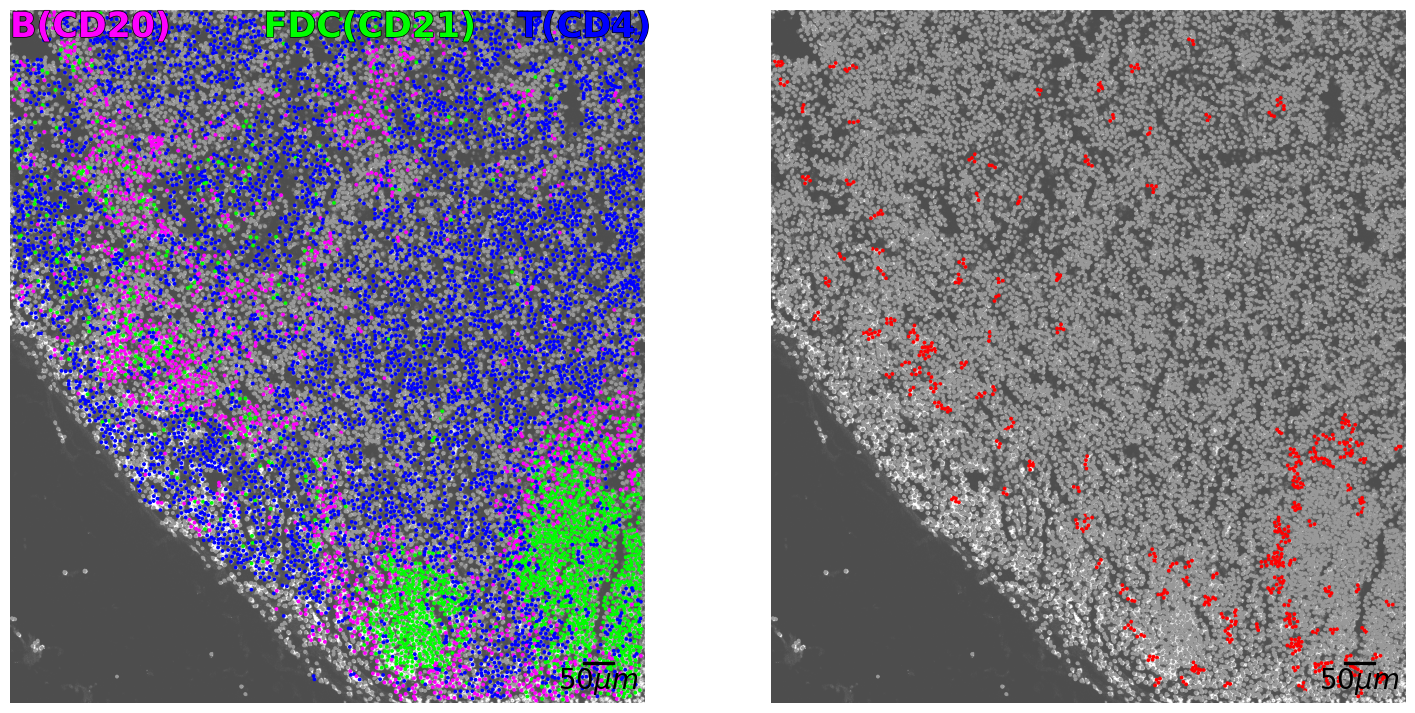

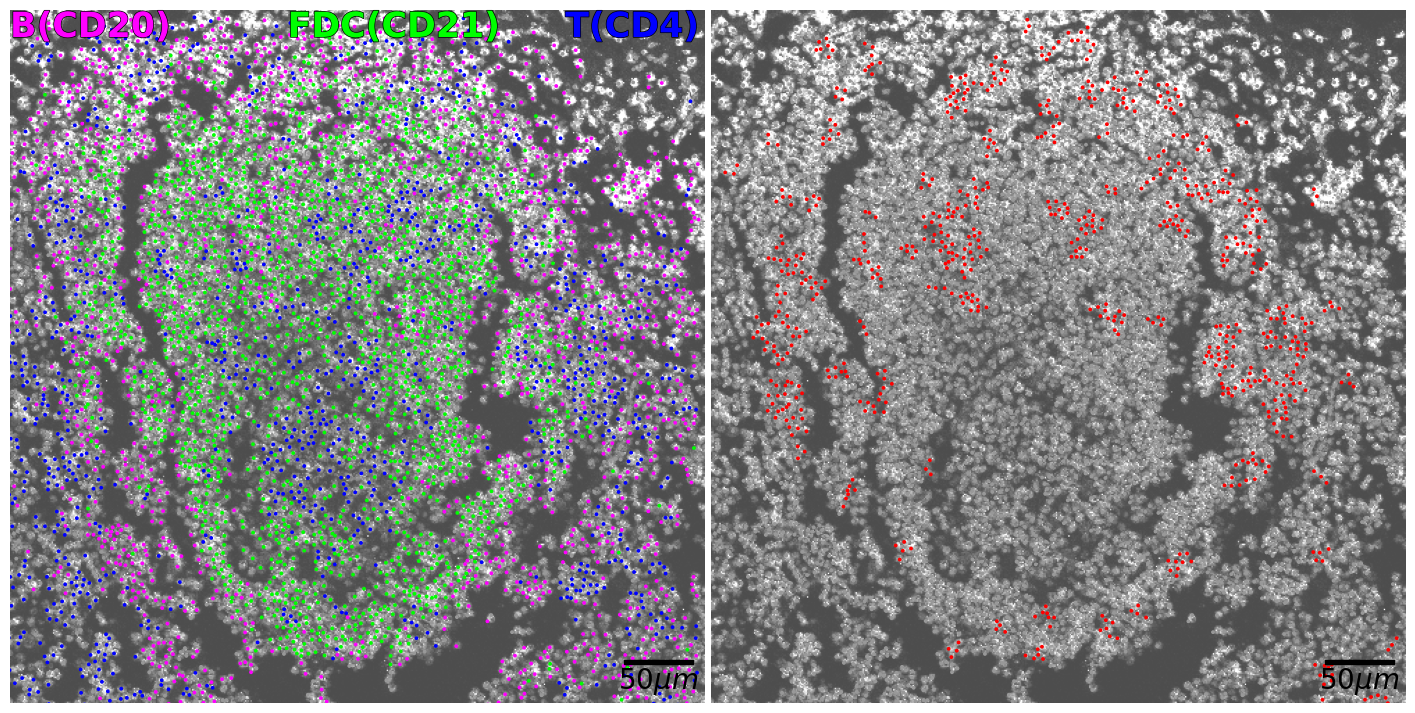

In [13]:
labels=['B(CD20)', 'FDC(CD21)', 'T(CD4)']
triplets_dict = {}

for roi in ROIs[1:2]:
    roi_df = df[df.ROI == roi]
    markers = ['CD20', 'CD21', 'CD4']
    colors = [[1,0,1,1], [0,1,0,1], [0,0,1,1]]
    marker2cell = {}

    # Read marker images and masks
    imgs, _ = get_imgs(h5_data, str(roi))
    mask = masks[str(roi)]
    avg_img = imgs[-1]
    
    # Get positif cells for indiviual markers
    for i, marker in enumerate(markers):
        cell_id = roi_df[roi_df[marker] > 0.2].Cell_label.tolist()
        marker2cell[marker] = cell_id

    # Get cell neighbors analysis
    distances, neighbors, cell_labels, graph, X = get_distances(mask)
    
    # cell to marker
    cell2marker = {}
    for i, cell in enumerate(cell_labels):
        for k,v in marker2cell.items():
            if cell in v:
                cell2marker[cell] = k
    
    node_colors = [[0.6, 0.6, 0.6, 1] for i in range(len(cell_labels))]
    for i, cell in enumerate(cell_labels):
        if cell in cell2marker.keys():
            node_colors[i] = colors[markers.index(cell2marker[cell])]
    
    # Get Triplets count
    triplets = 0
    node_colors_triplets = [[0.6, 0.6, 0.6, 1] for i in range(len(cell_labels))]
    for i, node in enumerate(cell_labels):
        if node in cell2marker.keys():
            node_label = cell2marker[node]
            neighbor = neighbors[i][1:]
            if len(neighbor) > 0:
                neighbor = [(idx, cell2marker[idx+1]) for idx in neighbor if idx+1 in cell2marker.keys()] # Get neighbor in positive cell types
                neighbor_cells = [idx for (idx, n) in neighbor if n != node_label] # Cell id of neighbor
                neighbor_labels = [n for (idx, n) in neighbor if n != node_label] # Cell type of neighbor
                if len(set(neighbor_labels)) == 2:
                    triplets += 1/3
                    node_colors_triplets[i] = [1,0,0,1]
                    for idx in neighbor_cells:
                        node_colors_triplets[idx] = [1,0,0,1]
    triplets_dict[roi] = triplets
    
    # Plot proximity map
    fig, ax = plt.subplots(1,2,figsize=(18,9))
    top, right = avg_img.shape
    ax[0].imshow(avg_img, cmap='gray', alpha=0.7, aspect='auto', extent=[0,right,0,top], origin='lower')
    plot_nn(X, graph, node_colors, ax[0])
    ax[0].invert_yaxis()
    for i, marker in enumerate(labels):
        color_text(0.4*i, 1, ax[0], marker, colors[i], fontsize=25, fontweight='bold')
    
    ax[1].imshow(avg_img, cmap='gray', alpha=0.7, aspect='auto', extent=[0,right,0,top], origin='lower')
    plot_nn(X, graph, node_colors_triplets, ax[1])
    ax[1].invert_yaxis()
    
    add_artist(ax[0])
    add_artist(ax[1])
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_xlim([500, 1000])
    ax[0].set_ylim([500, 1000])
    ax[1].set_xlim([500, 1000])
    ax[1].set_ylim([500, 1000])
    fig.subplots_adjust(wspace=0.01)
    plt.show()

In [ ]:
df_count = pd.DataFrame.from_dict(triplets_dict, orient='index').reset_index()
df_count.columns = ['ROI', 'Triplets Count']
df_count = df_count.sort_values('ROI')
df_count['ROI'] = df_count['ROI'].astype(str)
df_count.drop([14], axis=0, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))
ax = sns.barplot(ax=ax, x='Triplets Count', y='ROI', data=df_count)
plt.show()